In [7]:
import sys
# sys.path
import ee
import pprint
from IPython.display import Image
# from image import Image as local_model
import openet.ssebop as local_model

In [8]:
# ! --NotebookApp.iopub_data_rate_limit 2000000.0
# ! NotebookApp.iopub_data_rate_limitFloat 2000000.0
# !conda config --NotebookApp.iopub_data_rate_limit 2000000.0
# !jupyter notebook --NotebookApp.iopub_data_rate_limit 2000000.0

In [9]:
try:
    ee.Initialize(use_cloud_api=True)
    print('worked')
except ee.EEException:
    ee.Authenticate()
    ee.Initialize(use_cloud_api=True)

worked


In [10]:
ndvi_palette = ['#EFE7E1', '#003300']
et_palette = [
    'DEC29B', 'E6CDA1', 'EDD9A6', 'F5E4A9', 'FFF4AD', 'C3E683', '6BCC5C', 
    '3BB369', '20998F', '1C8691', '16678A', '114982', '0B2C7A']
image_size = 768

In [11]:
# landsat_id = 'LC08_035035_20190707' # Farmington, NM
# landsat_id = 'LC08_028030_20200825' # SiouxFalls, SD
# landsat_id = 'LC08_039034_20190703' # SE Nevada
# landsat_id = 'LC08_044033_20190127' # Sacramento, CA
# landsat_id = 'LE07_032038_20150104' # El Paso, TX
# landsat_id = 'LC08_021033_20150115' # Indianapolis
#LE07_023036_20150105
#LE07_028041_20150124
landsat_id = 'LC08_021033_20150115' 

In [12]:
landsat_img = ee.Image('LANDSAT/LC08/C01/T1_TOA/'+landsat_id) #LANDSAT/LC08/C01/T1_TOA

landsat_crs = landsat_img.select('B3').projection().getInfo()['crs']
landsat_region = landsat_img.geometry().bounds(1, 'EPSG:4326')
landsat_dt = ee.Date(landsat_img.get('system:time_start'))

In [13]:
# Build the SSEBop object from the Landsat image
model_obj = local_model.Image.from_landsat_c1_toa(
    landsat_img,
    et_reference_source='IDAHO_EPSCOR/GRIDMET', 
    et_reference_band='etr', 
    et_reference_factor=0.85,
    et_reference_resample='nearest',
    tcorr_source='GRIDDED',
)

Hello World!


In [14]:
ndvi_image = model_obj.ndvi
print(ndvi_image.getInfo())

{'type': 'Image', 'bands': [{'id': 'ndvi', 'data_type': {'type': 'PixelType', 'precision': 'float', 'min': -1, 'max': 1}, 'dimensions': [7691, 7811], 'crs': 'EPSG:32616', 'crs_transform': [30, 0, 458385, 0, -30, 4423215]}], 'id': 'LANDSAT/LC08/C01/T1_TOA/LC08_021033_20150115', 'properties': {'system:time_start': 1421339013490, 'image_id': 'LANDSAT/LC08/C01/T1_TOA/LC08_021033_20150115', 'system:index': 'LC08_021033_20150115'}}


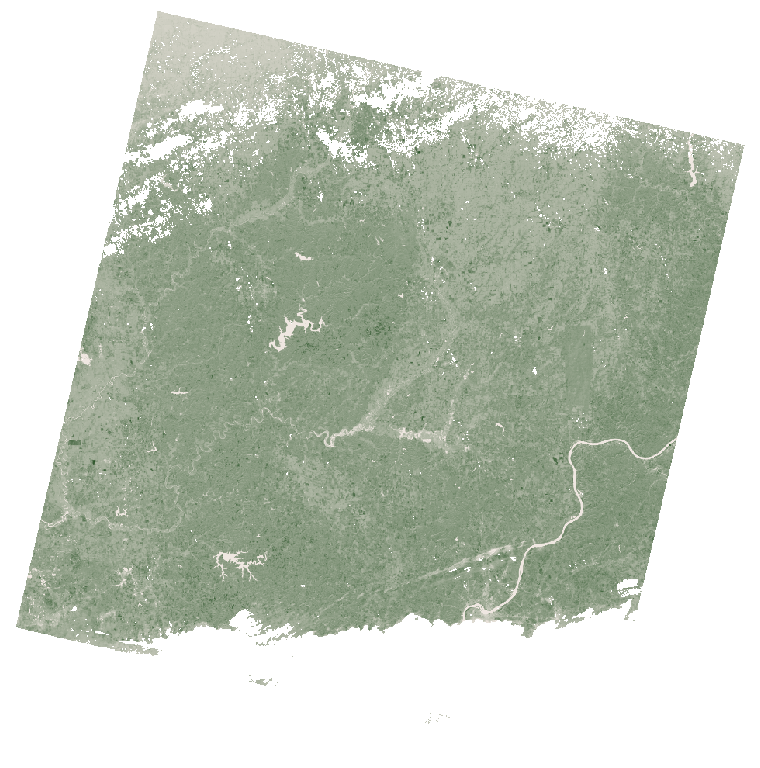

In [15]:
# # this might work for ndvi but not for higher processing images like SSEBop
image_url = model_obj.ndvi\
    .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
                  'region': landsat_region, 'dimensions': image_size})
Image(image_url, embed=True, format='png')

In [16]:
# tcorr_image = model_obj.tcorr_image_gridded_weight
tcorr_image = model_obj.tcorr_gridded
# # # print('get image tcorr \n', tcorr_image.getInfo())
# image_url = tcorr_image\
#     .getThumbURL({'min': -0.1, 'max': 0.9, 'palette': ndvi_palette, 
#                   'region': landsat_region, 'dimensions': image_size})
# print('image url \n', image_url)


In [17]:
def ee_task_start(task, n=10):
    """Make an exponential backoff Earth Engine request"""
    output = None
    for i in range(1, n):
        try:
            task.start()
            break
        except Exception as e:
            time.sleep(i ** 2)
    return task

In [18]:
# try to export and see if the image looks like expected.
task = ee.batch.Export.image.toDrive(image=tcorr_image, description='CFact_TestGTE', region=landsat_region)
task = ee.batch.Export.image.toAsset(image=tcorr_image, description='Tcorr10x10_finalsmooth_'+landsat_id, assetId='users/mof1452/gridC_march/Tcorr10x10_finalsmooth_'+landsat_id, region=landsat_region)
# start the task
print('starting')
ee_task_start(task=task)
print('task submitted')

starting
task submitted


In [19]:
# EToF = model_obj.et_fraction
# print(EToF.getInfo())

In [20]:
# # try to export EToF (Doesn't work. Error is "Error: Too many input pixels per output pixel. Need 27778, but only 64 allowed." Like Whaaaaat)
# task = ee.batch.Export.image.toAsset(image=EToF, description='ETf_'+landsat_id, assetId='users/mof1452/gridC/ETf__BlendedgriddedC_'+landsat_id, region=landsat_region)
# # start the task
# print('starting')
# ee_task_start(task=task)
# print('task submitted')